In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from deep_boltzmann.models import MuellerPotential
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

### 0. Utils

In [3]:
xgrid = np.linspace(-1.5, 1.0, 100)
ygrid = np.linspace(-0.5, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

In [4]:
def plot_KLML(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    '''
    plot KL ML loss together
    '''
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    losses_ML_val = np.concatenate([hist_ML[1], hist_KL[2][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='steelblue',label='traning loss')
    axes[0].plot(xticks, losses_ML_val, color='darkorange',label='validation loss')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].legend(ncol=1, loc='upper right', frameon=False)
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    losses_KL_val = hist_KL[2][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='steelblue',label='traning loss')
    axes[1].plot(xticks, losses_KL_val, color='darkorange',label='validation loss')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].legend(ncol=1, loc='upper right', frameon=False)
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    
    return fig, axes

In [5]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [6]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [7]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [8]:
def plot_potential(labels=True, cbar=True, figsize=(5, 4), orientation='vertical'):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    return cbar

In [9]:
def getx(x):
    return x[:, 0]
def gety(x):
    return x[:, 1]

### 1. Explore Mueller Potential

In [10]:
params = MuellerPotential.params_default.copy()
params['k'] = 0.1
params['dim'] = 2
mueller = MuellerPotential(params=params)

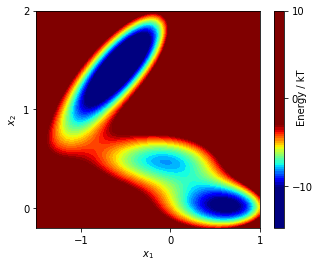

In [11]:
plot_potential(labels=True, cbar=True)

### 2. Generate Simulation Data

In [12]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [66]:
nsteps = 10000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

In [67]:
x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

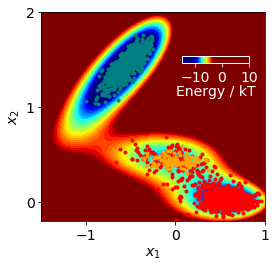

In [68]:
cbar = plot_potential(labels=True, cbar=True, figsize=(4, 5.5), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/mueller/potential_horizontal.pdf', bbox_inches='tight', transparent=True)

In [69]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

### 3. Training using InvNet

In [58]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

### 3.1 Pure ML loss training

In [70]:
network1 = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [71]:
hist_ML = network1.train_ML(x, xval=xval, epochs=700, batch_size=128, std=1.0, verbose=1,
                   return_test_energies=True)


Epoch 0/700 loss 0.7352 0.5649 
Epoch 1/700 loss 0.5132 0.3098 
Epoch 2/700 loss 0.3648 0.1804 
Epoch 3/700 loss 0.2301 0.1524 
Epoch 4/700 loss 0.1318 0.0089 
Epoch 5/700 loss 0.0185 -0.0482 
Epoch 6/700 loss -0.0521 -0.1271 
Epoch 7/700 loss -0.1501 -0.1645 
Epoch 8/700 loss -0.1270 -0.2493 
Epoch 9/700 loss -0.2438 -0.3484 
Epoch 10/700 loss -0.2723 -0.3231 
Epoch 11/700 loss -0.4569 -0.5036 
Epoch 12/700 loss -0.5884 -0.5780 
Epoch 13/700 loss -0.5281 -0.5529 
Epoch 14/700 loss -0.4848 -0.5396 


/home/fanglin/Boltzmann_Generators/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


Epoch 15/700 loss -0.5328 -0.5587 
Epoch 16/700 loss -0.4891 -0.4918 
Epoch 17/700 loss -0.4377 -0.5242 
Epoch 18/700 loss -0.5287 -0.6836 
Epoch 19/700 loss -0.7024 -0.7531 
Epoch 20/700 loss -0.8095 -0.7033 
Epoch 21/700 loss -0.8251 -0.8308 
Epoch 22/700 loss -0.7400 -0.7921 
Epoch 23/700 loss -0.9940 -0.9170 
Epoch 24/700 loss -0.7880 -0.9559 
Epoch 25/700 loss -0.9941 -0.9695 
Epoch 26/700 loss -1.0168 -1.0939 
Epoch 27/700 loss -0.9626 -1.0962 
Epoch 28/700 loss -1.1248 -1.1327 
Epoch 29/700 loss -1.0569 -1.2387 
Epoch 30/700 loss -1.1282 -1.0911 
Epoch 31/700 loss -1.1981 -1.1809 
Epoch 32/700 loss -1.2891 -0.8107 
Epoch 33/700 loss -1.3883 -1.4159 
Epoch 34/700 loss -1.2341 -1.4229 
Epoch 35/700 loss -1.4072 -1.4781 
Epoch 36/700 loss -1.4399 -1.4672 
Epoch 37/700 loss -1.3833 -1.2915 
Epoch 38/700 loss -1.4447 -0.5109 
Epoch 39/700 loss -1.4330 -1.1640 
Epoch 40/700 loss -1.4021 -1.5543 
Epoch 41/700 loss -1.5324 -1.3915 
Epoch 42/700 loss -1.5699 -1.5897 
Epoch 43/700 loss -1

Epoch 245/700 loss -2.7246 -2.5011 
Epoch 246/700 loss -2.5989 -2.4671 
Epoch 247/700 loss -2.5195 -2.5717 
Epoch 248/700 loss -2.5021 -2.6118 
Epoch 249/700 loss -2.5367 -2.5659 
Epoch 250/700 loss -2.5823 -2.3747 
Epoch 251/700 loss -2.5825 -2.6153 
Epoch 252/700 loss -2.4660 -2.6306 
Epoch 253/700 loss -2.7992 -2.5091 
Epoch 254/700 loss -2.5583 -2.1035 
Epoch 255/700 loss -2.3508 -2.5095 
Epoch 256/700 loss -2.5779 -2.7197 
Epoch 257/700 loss -2.6623 -2.5481 
Epoch 258/700 loss -2.6522 -2.6729 
Epoch 259/700 loss -2.5754 -2.4886 
Epoch 260/700 loss -2.3341 -2.6923 
Epoch 261/700 loss -2.3526 -2.5767 
Epoch 262/700 loss -2.5688 -2.3900 
Epoch 263/700 loss -2.7571 -2.7209 
Epoch 264/700 loss -2.6107 -2.4758 
Epoch 265/700 loss -2.6949 -2.7294 
Epoch 266/700 loss -2.6021 -2.6561 
Epoch 267/700 loss -2.4744 -2.5671 
Epoch 268/700 loss -2.6849 -2.4957 
Epoch 269/700 loss -2.5369 -2.6642 
Epoch 270/700 loss -2.6521 -2.4360 
Epoch 271/700 loss -2.5825 -2.6050 
Epoch 272/700 loss -2.6710 -

Epoch 473/700 loss -2.5033 -2.5625 
Epoch 474/700 loss -2.5335 -2.5452 
Epoch 475/700 loss -2.5278 -2.6484 
Epoch 476/700 loss -2.6124 -2.6655 
Epoch 477/700 loss -2.5963 -2.4124 
Epoch 478/700 loss -2.5247 -2.6182 
Epoch 479/700 loss -2.5523 -2.6310 
Epoch 480/700 loss -2.6060 -2.5840 
Epoch 481/700 loss -2.7722 -2.6163 
Epoch 482/700 loss -2.6176 -2.6281 
Epoch 483/700 loss -2.6655 -2.4653 
Epoch 484/700 loss -2.6989 -2.5656 
Epoch 485/700 loss -2.6564 -2.5509 
Epoch 486/700 loss -2.5781 -2.6348 
Epoch 487/700 loss -2.6715 -2.6025 
Epoch 488/700 loss -2.5863 -2.1431 
Epoch 489/700 loss -2.2836 -2.6399 
Epoch 490/700 loss -2.5911 -2.6256 
Epoch 491/700 loss -2.7145 -2.7019 
Epoch 492/700 loss -2.4783 -2.6010 
Epoch 493/700 loss -2.6914 -2.7008 
Epoch 494/700 loss -2.7523 -2.3863 
Epoch 495/700 loss -2.7274 -2.5639 
Epoch 496/700 loss -2.6083 -2.7111 
Epoch 497/700 loss -2.7277 -2.6572 
Epoch 498/700 loss -2.6695 -2.5767 
Epoch 499/700 loss -2.2209 -2.4592 
Epoch 500/700 loss -2.5587 -

### 3.2 Pure KL loss training

In [72]:
network2 = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [73]:
hist_KL = network2.train_flexible(x, xval=xval, lr=0.001, epochs=700, batch_size=1000, std=1.0,
                          weight_ML=0.01, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                          weight_RCEnt=1.0, rc_func=gety, rc_min=-0.1, rc_max=1.7,
                          temperature=1.0, explore=1.0, verbose=1, return_test_energies=True)

Epoch 0/700 loss 52.1873 46.4484 index_layer_57_loss 0.7550 0.5176 index_layer_60_loss 24.3374 18.5260 index_layer_60_loss 27.8423 27.9172 
Epoch 1/700 loss 47.3162 42.7105 index_layer_57_loss 0.4772 0.4518 index_layer_60_loss 19.4900 15.1413 index_layer_60_loss 27.8215 27.5648 
Epoch 2/700 loss 40.6685 39.6296 index_layer_57_loss 0.4505 0.4414 index_layer_60_loss 13.1071 12.4492 index_layer_60_loss 27.5569 27.1760 
Epoch 3/700 loss 41.2746 37.8125 index_layer_57_loss 0.4569 0.4542 index_layer_60_loss 14.2136 10.8709 index_layer_60_loss 27.0564 26.9370 
Epoch 4/700 loss 38.4353 36.0237 index_layer_57_loss 0.4568 0.5145 index_layer_60_loss 11.2968 8.9967 index_layer_60_loss 27.1339 27.0219 
Epoch 5/700 loss 35.6425 34.1001 index_layer_57_loss 0.5144 0.5910 index_layer_60_loss 8.6482 7.1525 index_layer_60_loss 26.9891 26.9417 
Epoch 6/700 loss 34.8304 33.0070 index_layer_57_loss 0.5625 0.6347 index_layer_60_loss 7.8169 6.0540 index_layer_60_loss 27.0079 26.9467 
Epoch 7/700 loss 32.6396 

/home/fanglin/Boltzmann_Generators/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


Epoch 20/700 loss 25.1304 25.6511 index_layer_57_loss 0.1287 0.3021 index_layer_60_loss -2.1292 -1.6211 index_layer_60_loss 27.2583 27.2691 
Epoch 21/700 loss 24.9973 24.4243 index_layer_57_loss 0.1475 0.2939 index_layer_60_loss -2.2056 -2.8098 index_layer_60_loss 27.2015 27.2312 
Epoch 22/700 loss 24.5103 24.3885 index_layer_57_loss 0.2565 0.2548 index_layer_60_loss -2.7618 -2.9089 index_layer_60_loss 27.2696 27.2949 
Epoch 23/700 loss 24.5342 23.8608 index_layer_57_loss 0.2165 0.1730 index_layer_60_loss -2.6243 -3.4173 index_layer_60_loss 27.1563 27.2764 
Epoch 24/700 loss 23.8011 24.0548 index_layer_57_loss 0.2375 0.1311 index_layer_60_loss -3.4971 -3.4331 index_layer_60_loss 27.2958 27.4866 
Epoch 25/700 loss 24.2421 24.1601 index_layer_57_loss 0.1415 0.2746 index_layer_60_loss -3.2340 -3.3694 index_layer_60_loss 27.4747 27.5268 
Epoch 26/700 loss 23.7156 23.5105 index_layer_57_loss 0.0894 0.4281 index_layer_60_loss -3.8595 -3.8848 index_layer_60_loss 27.5743 27.3910 
Epoch 27/700 

Epoch 78/700 loss 21.9446 21.9463 index_layer_57_loss -0.7826 -0.6413 index_layer_60_loss -4.8312 -4.8838 index_layer_60_loss 26.7837 26.8365 
Epoch 79/700 loss 21.7322 22.0210 index_layer_57_loss -0.7703 -0.8073 index_layer_60_loss -5.0517 -4.8263 index_layer_60_loss 26.7917 26.8554 
Epoch 80/700 loss 21.8144 21.5520 index_layer_57_loss -0.7877 -0.8944 index_layer_60_loss -4.9688 -5.3918 index_layer_60_loss 26.7911 26.9527 
Epoch 81/700 loss 21.9393 21.7492 index_layer_57_loss -0.8906 -0.9670 index_layer_60_loss -4.8934 -5.1260 index_layer_60_loss 26.8416 26.8848 
Epoch 82/700 loss 21.9770 21.8442 index_layer_57_loss -0.9862 -0.9856 index_layer_60_loss -4.8160 -5.0559 index_layer_60_loss 26.8029 26.9100 
Epoch 83/700 loss 21.7641 21.6085 index_layer_57_loss -1.0167 -0.9529 index_layer_60_loss -5.0052 -5.2557 index_layer_60_loss 26.7795 26.8737 
Epoch 84/700 loss 21.7903 21.5962 index_layer_57_loss -1.0523 -0.9882 index_layer_60_loss -5.1638 -5.0826 index_layer_60_loss 26.9646 26.6887 

Epoch 136/700 loss 20.0799 20.1917 index_layer_57_loss -1.6062 -1.6623 index_layer_60_loss -6.8575 -6.8663 index_layer_60_loss 26.9535 27.0746 
Epoch 137/700 loss 20.0937 20.2307 index_layer_57_loss -1.7365 -1.5724 index_layer_60_loss -6.9159 -6.8521 index_layer_60_loss 27.0270 27.0985 
Epoch 138/700 loss 20.0347 20.0552 index_layer_57_loss -1.7374 -1.6714 index_layer_60_loss -6.8977 -6.8953 index_layer_60_loss 26.9498 26.9672 
Epoch 139/700 loss 20.1807 20.1206 index_layer_57_loss -1.6716 -1.5860 index_layer_60_loss -6.9335 -6.8454 index_layer_60_loss 27.1309 26.9819 
Epoch 140/700 loss 20.1176 20.0526 index_layer_57_loss -1.7197 -1.4839 index_layer_60_loss -6.9033 -6.8868 index_layer_60_loss 27.0381 26.9541 
Epoch 141/700 loss 20.0092 20.0304 index_layer_57_loss -1.5769 -1.5252 index_layer_60_loss -6.7385 -6.9077 index_layer_60_loss 26.7635 26.9533 
Epoch 142/700 loss 20.1749 20.0241 index_layer_57_loss -1.6897 -1.7980 index_layer_60_loss -6.5451 -6.9243 index_layer_60_loss 26.7368 2

Epoch 193/700 loss 19.7247 19.7014 index_layer_57_loss -1.9933 -1.8674 index_layer_60_loss -7.0392 -7.0052 index_layer_60_loss 26.7838 26.7253 
Epoch 194/700 loss 19.6990 19.6743 index_layer_57_loss -2.0001 -1.9200 index_layer_60_loss -7.0768 -7.0082 index_layer_60_loss 26.7958 26.7017 
Epoch 195/700 loss 19.6919 19.7512 index_layer_57_loss -1.9292 -1.7866 index_layer_60_loss -7.0076 -7.0303 index_layer_60_loss 26.7188 26.7994 
Epoch 196/700 loss 19.7249 19.7449 index_layer_57_loss -1.8916 -1.8937 index_layer_60_loss -7.2051 -7.0191 index_layer_60_loss 26.9489 26.7830 
Epoch 197/700 loss 19.7255 19.8328 index_layer_57_loss -1.9273 -1.8203 index_layer_60_loss -6.9473 -6.8653 index_layer_60_loss 26.6920 26.7163 
Epoch 198/700 loss 19.7246 19.6360 index_layer_57_loss -2.0580 -2.1201 index_layer_60_loss -6.9646 -7.2138 index_layer_60_loss 26.7098 26.8710 
Epoch 199/700 loss 19.6628 19.7536 index_layer_57_loss -2.0868 -2.0045 index_layer_60_loss -7.0699 -7.0640 index_layer_60_loss 26.7536 2

Epoch 250/700 loss 19.5598 19.6063 index_layer_57_loss -2.1232 -2.1827 index_layer_60_loss -7.2285 -7.1369 index_layer_60_loss 26.8094 26.7650 
Epoch 251/700 loss 19.5782 19.6025 index_layer_57_loss -2.1120 -2.0138 index_layer_60_loss -7.2328 -7.2737 index_layer_60_loss 26.8321 26.8963 
Epoch 252/700 loss 19.5743 19.5945 index_layer_57_loss -2.0057 -2.0271 index_layer_60_loss -7.1076 -7.1697 index_layer_60_loss 26.7020 26.7845 
Epoch 253/700 loss 19.7098 19.6058 index_layer_57_loss -2.0734 -2.0425 index_layer_60_loss -7.0488 -7.1119 index_layer_60_loss 26.7794 26.7381 
Epoch 254/700 loss 19.5225 19.6314 index_layer_57_loss -1.9576 -1.9132 index_layer_60_loss -7.1705 -7.0217 index_layer_60_loss 26.7126 26.6722 
Epoch 255/700 loss 19.6467 19.6262 index_layer_57_loss -1.9303 -2.0258 index_layer_60_loss -7.0925 -7.1921 index_layer_60_loss 26.7584 26.8385 
Epoch 256/700 loss 19.6097 19.5793 index_layer_57_loss -1.9650 -2.0109 index_layer_60_loss -7.1943 -7.0689 index_layer_60_loss 26.8237 2

Epoch 307/700 loss 19.6000 19.5555 index_layer_57_loss -2.0832 -2.0253 index_layer_60_loss -7.2704 -7.1615 index_layer_60_loss 26.8912 26.7373 
Epoch 308/700 loss 19.5060 19.5492 index_layer_57_loss -2.0697 -2.1657 index_layer_60_loss -7.2691 -7.1188 index_layer_60_loss 26.7958 26.6896 
Epoch 309/700 loss 19.5640 19.5179 index_layer_57_loss -2.2495 -2.0766 index_layer_60_loss -7.1157 -7.1875 index_layer_60_loss 26.7023 26.7261 
Epoch 310/700 loss 19.5480 19.5799 index_layer_57_loss -2.0536 -2.0560 index_layer_60_loss -7.1336 -7.1600 index_layer_60_loss 26.7021 26.7605 
Epoch 311/700 loss 19.5340 19.6925 index_layer_57_loss -2.1232 -1.9667 index_layer_60_loss -7.2135 -7.0687 index_layer_60_loss 26.7687 26.7809 
Epoch 312/700 loss 19.5760 19.5345 index_layer_57_loss -2.1046 -2.0617 index_layer_60_loss -7.0807 -7.2204 index_layer_60_loss 26.6778 26.7755 
Epoch 313/700 loss 19.6145 19.5684 index_layer_57_loss -2.1655 -2.0911 index_layer_60_loss -7.0606 -7.0620 index_layer_60_loss 26.6967 2

Epoch 364/700 loss 19.5137 19.5403 index_layer_57_loss -2.1307 -2.1638 index_layer_60_loss -7.1229 -7.1628 index_layer_60_loss 26.6579 26.7248 
Epoch 365/700 loss 19.5230 19.5456 index_layer_57_loss -2.0300 -2.1204 index_layer_60_loss -7.1348 -7.1919 index_layer_60_loss 26.6781 26.7586 
Epoch 366/700 loss 19.5249 19.5298 index_layer_57_loss -2.0765 -2.1467 index_layer_60_loss -7.3261 -7.2214 index_layer_60_loss 26.8717 26.7727 
Epoch 367/700 loss 19.5082 19.5366 index_layer_57_loss -2.1717 -2.1644 index_layer_60_loss -7.4008 -7.3054 index_layer_60_loss 26.9307 26.8637 
Epoch 368/700 loss 19.5347 19.5323 index_layer_57_loss -2.0671 -2.2066 index_layer_60_loss -7.3033 -7.1858 index_layer_60_loss 26.8587 26.7401 
Epoch 369/700 loss 19.5663 19.5299 index_layer_57_loss -2.1084 -2.1156 index_layer_60_loss -7.2377 -7.1729 index_layer_60_loss 26.8251 26.7240 
Epoch 370/700 loss 19.5320 19.5259 index_layer_57_loss -2.0429 -2.1510 index_layer_60_loss -7.2749 -7.2340 index_layer_60_loss 26.8273 2

Epoch 421/700 loss 19.4956 19.5587 index_layer_57_loss -2.1430 -2.1181 index_layer_60_loss -7.1539 -7.0811 index_layer_60_loss 26.6710 26.6610 
Epoch 422/700 loss 19.5450 19.5417 index_layer_57_loss -2.1308 -2.0369 index_layer_60_loss -7.1124 -7.0793 index_layer_60_loss 26.6787 26.6414 
Epoch 423/700 loss 19.5018 19.5689 index_layer_57_loss -2.1657 -2.1546 index_layer_60_loss -7.1727 -7.0536 index_layer_60_loss 26.6961 26.6440 
Epoch 424/700 loss 19.5488 19.4906 index_layer_57_loss -2.0660 -2.1784 index_layer_60_loss -7.1343 -7.2794 index_layer_60_loss 26.7037 26.7918 
Epoch 425/700 loss 19.5225 19.5533 index_layer_57_loss -2.1269 -2.0644 index_layer_60_loss -7.2752 -7.1943 index_layer_60_loss 26.8189 26.7683 
Epoch 426/700 loss 19.5383 19.5317 index_layer_57_loss -2.1608 -2.2000 index_layer_60_loss -7.1017 -7.1214 index_layer_60_loss 26.6616 26.6751 
Epoch 427/700 loss 19.5357 19.5570 index_layer_57_loss -2.2187 -2.1710 index_layer_60_loss -7.2263 -7.2483 index_layer_60_loss 26.7842 2

Epoch 478/700 loss 19.5363 19.4554 index_layer_57_loss -2.1616 -2.2497 index_layer_60_loss -7.1889 -7.2000 index_layer_60_loss 26.7467 26.6780 
Epoch 479/700 loss 19.5846 19.4866 index_layer_57_loss -2.1732 -2.1689 index_layer_60_loss -7.3128 -7.2029 index_layer_60_loss 26.9191 26.7112 
Epoch 480/700 loss 19.4701 19.5030 index_layer_57_loss -2.3301 -2.2326 index_layer_60_loss -7.1817 -7.1504 index_layer_60_loss 26.6750 26.6757 
Epoch 481/700 loss 19.5366 19.4784 index_layer_57_loss -2.2527 -2.1954 index_layer_60_loss -7.1354 -7.2270 index_layer_60_loss 26.6945 26.7273 
Epoch 482/700 loss 19.5333 19.4926 index_layer_57_loss -2.1730 -2.2034 index_layer_60_loss -7.1218 -7.2399 index_layer_60_loss 26.6769 26.7545 
Epoch 483/700 loss 19.4877 19.4685 index_layer_57_loss -2.1303 -2.2519 index_layer_60_loss -7.1511 -7.1547 index_layer_60_loss 26.6602 26.6457 
Epoch 484/700 loss 19.4696 19.4622 index_layer_57_loss -2.1589 -2.1574 index_layer_60_loss -7.2524 -7.1745 index_layer_60_loss 26.7435 2

Epoch 535/700 loss 19.5292 19.5203 index_layer_57_loss -2.2914 -2.1672 index_layer_60_loss -7.2536 -7.3113 index_layer_60_loss 26.8057 26.8533 
Epoch 536/700 loss 19.4584 19.4467 index_layer_57_loss -2.1651 -2.2470 index_layer_60_loss -7.2336 -7.4775 index_layer_60_loss 26.7137 26.9466 
Epoch 537/700 loss 19.6233 19.4684 index_layer_57_loss -2.2172 -2.3012 index_layer_60_loss -7.4742 -7.3385 index_layer_60_loss 27.1197 26.8300 
Epoch 538/700 loss 19.5614 19.5387 index_layer_57_loss -2.2851 -2.2571 index_layer_60_loss -7.2673 -7.2766 index_layer_60_loss 26.8516 26.8378 
Epoch 539/700 loss 19.5267 19.6248 index_layer_57_loss -2.2309 -2.1901 index_layer_60_loss -7.2561 -7.3943 index_layer_60_loss 26.8051 27.0410 
Epoch 540/700 loss 19.4703 19.4387 index_layer_57_loss -2.1614 -2.2134 index_layer_60_loss -7.3035 -7.2906 index_layer_60_loss 26.7954 26.7514 
Epoch 541/700 loss 19.4917 19.4858 index_layer_57_loss -2.2550 -2.2189 index_layer_60_loss -7.2558 -7.2227 index_layer_60_loss 26.7701 2

Epoch 592/700 loss 19.4462 19.4952 index_layer_57_loss -2.2092 -2.1437 index_layer_60_loss -7.2962 -7.1226 index_layer_60_loss 26.7645 26.6392 
Epoch 593/700 loss 19.4700 19.4687 index_layer_57_loss -2.2579 -2.2176 index_layer_60_loss -7.2345 -7.2617 index_layer_60_loss 26.7272 26.7525 
Epoch 594/700 loss 19.5276 19.5096 index_layer_57_loss -2.2827 -2.2482 index_layer_60_loss -7.1599 -7.1813 index_layer_60_loss 26.7103 26.7133 
Epoch 595/700 loss 19.5144 19.5259 index_layer_57_loss -2.2234 -2.2453 index_layer_60_loss -7.1803 -7.2759 index_layer_60_loss 26.7169 26.8242 
Epoch 596/700 loss 19.5343 19.4912 index_layer_57_loss -2.1961 -2.2583 index_layer_60_loss -7.2673 -7.2034 index_layer_60_loss 26.8236 26.7172 
Epoch 597/700 loss 19.4881 19.4025 index_layer_57_loss -2.2572 -2.3071 index_layer_60_loss -7.2197 -7.2496 index_layer_60_loss 26.7304 26.6752 
Epoch 598/700 loss 19.4783 19.5219 index_layer_57_loss -2.2587 -2.2746 index_layer_60_loss -7.3790 -7.2583 index_layer_60_loss 26.8799 2

Epoch 649/700 loss 19.4663 19.5059 index_layer_57_loss -2.2910 -2.2413 index_layer_60_loss -7.3596 -7.2243 index_layer_60_loss 26.8487 26.7526 
Epoch 650/700 loss 19.5277 19.4816 index_layer_57_loss -2.2367 -2.2008 index_layer_60_loss -7.2208 -7.1165 index_layer_60_loss 26.7708 26.6201 
Epoch 651/700 loss 19.4816 19.4947 index_layer_57_loss -2.2191 -2.1641 index_layer_60_loss -7.2306 -7.1018 index_layer_60_loss 26.7344 26.6181 
Epoch 652/700 loss 19.4676 19.5739 index_layer_57_loss -2.1651 -2.1545 index_layer_60_loss -7.1802 -7.3214 index_layer_60_loss 26.6694 26.9168 
Epoch 653/700 loss 19.5946 19.5948 index_layer_57_loss -2.1529 -2.0833 index_layer_60_loss -7.2086 -7.1242 index_layer_60_loss 26.8248 26.7398 
Epoch 654/700 loss 19.6108 19.5212 index_layer_57_loss -2.2102 -2.3087 index_layer_60_loss -7.1850 -7.0699 index_layer_60_loss 26.8180 26.6142 
Epoch 655/700 loss 19.4719 19.4741 index_layer_57_loss -2.1895 -2.2393 index_layer_60_loss -7.2208 -7.3217 index_layer_60_loss 26.7145 2

### Compare ML vs KL loss

Text(0, 0.5, 'KL loss')

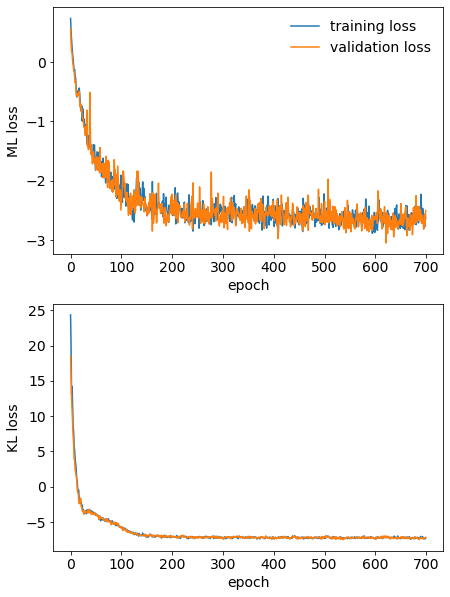

In [74]:
from matplotlib import rcParams
rcParams.update({'font.size':14})

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,10))
axes[0].plot(list(range(700)), hist_ML[0], label='training loss')
axes[0].plot(list(range(700)), hist_ML[1], label='validation loss')
axes[0].legend(ncol=1, loc='upper right', frameon=False)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('ML loss')


axes[1].plot(list(range(700)), hist_KL[1][:,2], label='training loss')
axes[1].plot(list(range(700)), hist_KL[2][:,2], label='validation loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('KL loss')

### 3.3 Joint learning

In [75]:
network3 = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, 
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [76]:
hist1 = network3.train_ML(x, xval=xval, epochs=200, batch_size=128, std=1.0, verbose=1,
                   return_test_energies=True)
hist2 = network3.train_flexible(x, xval=xval, lr=0.001, epochs=500, batch_size=1000, std=1.0,
                          weight_ML=1.0, weight_KL=1.0, weight_MC=0.0, weight_W2=0.0,
                          weight_RCEnt=1.0, rc_func=gety, rc_min=-0.1, rc_max=1.7,
                          temperature=1.0, explore=1.0, verbose=1, return_test_energies=True)

Epoch 0/200 loss 0.7413 0.4962 
Epoch 1/200 loss 0.5322 0.3528 
Epoch 2/200 loss 0.3356 0.2551 
Epoch 3/200 loss 0.2579 0.1063 
Epoch 4/200 loss 0.1488 0.0442 
Epoch 5/200 loss 0.0572 -0.0205 
Epoch 6/200 loss -0.0099 -0.0721 
Epoch 7/200 loss -0.0821 -0.1496 
Epoch 8/200 loss -0.1383 -0.1956 
Epoch 9/200 loss -0.2476 -0.2352 
Epoch 10/200 loss -0.2650 -0.2894 
Epoch 11/200 loss -0.2970 -0.4417 
Epoch 12/200 loss -0.4728 -0.5967 
Epoch 13/200 loss -0.5930 -0.4888 
Epoch 14/200 loss -0.6190 -0.5612 
Epoch 15/200 loss -0.7278 -0.4438 
Epoch 16/200 loss -0.7390 0.0098 
Epoch 17/200 loss -0.6472 -0.7605 


/home/fanglin/Boltzmann_Generators/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


Epoch 18/200 loss -0.6986 -0.7179 
Epoch 19/200 loss -0.7243 -0.7097 
Epoch 20/200 loss -0.8535 -0.8677 
Epoch 21/200 loss -0.8373 -0.9398 
Epoch 22/200 loss -0.8841 -0.7815 
Epoch 23/200 loss -0.8385 -0.8499 
Epoch 24/200 loss -0.9121 -0.9667 
Epoch 25/200 loss -0.9073 -0.8959 
Epoch 26/200 loss -0.9940 -1.0044 
Epoch 27/200 loss -1.0456 -0.9540 
Epoch 28/200 loss -1.0889 -1.2249 
Epoch 29/200 loss -1.0932 -1.1953 
Epoch 30/200 loss -1.1912 -1.1739 
Epoch 31/200 loss -1.2208 -1.0725 
Epoch 32/200 loss -1.2063 -1.0842 
Epoch 33/200 loss -1.3091 -1.3122 
Epoch 34/200 loss -1.2102 -0.8459 
Epoch 35/200 loss -1.3149 -1.2045 
Epoch 36/200 loss -1.2036 -1.4062 
Epoch 37/200 loss -1.3902 -1.4830 
Epoch 38/200 loss -1.4596 -1.4717 
Epoch 39/200 loss -1.4150 -1.2686 
Epoch 40/200 loss -1.5731 -1.4845 
Epoch 41/200 loss -1.3482 -1.3975 
Epoch 42/200 loss -1.3982 -1.5728 
Epoch 43/200 loss -1.4100 -1.3835 
Epoch 44/200 loss -1.5029 -1.5651 
Epoch 45/200 loss -1.5227 -1.3679 
Epoch 46/200 loss -1

Epoch 13/500 loss 17.6675 17.7695 index_layer_63_loss -2.2713 -2.2070 index_layer_66_loss -7.0135 -7.0211 index_layer_66_loss 26.9523 26.9976 
Epoch 14/500 loss 17.5982 18.0160 index_layer_63_loss -2.2056 -2.1515 index_layer_66_loss -7.1110 -7.0692 index_layer_66_loss 26.9148 27.2367 
Epoch 15/500 loss 18.0314 18.0033 index_layer_63_loss -2.1674 -2.1555 index_layer_66_loss -7.0862 -6.7411 index_layer_66_loss 27.2850 26.8999 
Epoch 16/500 loss 17.9591 17.4990 index_layer_63_loss -2.1724 -2.3057 index_layer_66_loss -6.9839 -7.0469 index_layer_66_loss 27.1155 26.8516 
Epoch 17/500 loss 17.5211 17.4993 index_layer_63_loss -2.2855 -2.2617 index_layer_66_loss -7.1512 -7.0216 index_layer_66_loss 26.9578 26.7825 
Epoch 18/500 loss 17.6458 17.8756 index_layer_63_loss -2.2603 -2.1935 index_layer_66_loss -6.9951 -6.7061 index_layer_66_loss 26.9013 26.7752 
Epoch 19/500 loss 17.7997 17.8778 index_layer_63_loss -2.1490 -2.1848 index_layer_66_loss -6.7911 -6.6998 index_layer_66_loss 26.7398 26.7624 

Epoch 71/500 loss 17.0891 17.1488 index_layer_63_loss -2.4099 -2.3995 index_layer_66_loss -7.4497 -7.2208 index_layer_66_loss 26.9488 26.7691 
Epoch 72/500 loss 17.0890 17.0791 index_layer_63_loss -2.3728 -2.3560 index_layer_66_loss -7.3433 -7.4956 index_layer_66_loss 26.8051 26.9307 
Epoch 73/500 loss 17.0655 16.9928 index_layer_63_loss -2.3802 -2.4262 index_layer_66_loss -7.4360 -7.3776 index_layer_66_loss 26.8816 26.7965 
Epoch 74/500 loss 17.1498 17.0737 index_layer_63_loss -2.4042 -2.4071 index_layer_66_loss -7.2093 -7.2535 index_layer_66_loss 26.7632 26.7343 
Epoch 75/500 loss 17.2263 17.1776 index_layer_63_loss -2.3588 -2.2955 index_layer_66_loss -7.3272 -7.2382 index_layer_66_loss 26.9123 26.7112 
Epoch 76/500 loss 17.0942 17.0583 index_layer_63_loss -2.3835 -2.4227 index_layer_66_loss -7.3083 -7.3034 index_layer_66_loss 26.7860 26.7844 
Epoch 77/500 loss 17.2346 17.1104 index_layer_63_loss -2.3633 -2.4319 index_layer_66_loss -7.1918 -7.3012 index_layer_66_loss 26.7896 26.8434 

Epoch 129/500 loss 17.2284 17.1305 index_layer_63_loss -2.3307 -2.3466 index_layer_66_loss -7.4061 -7.2731 index_layer_66_loss 26.9652 26.7502 
Epoch 130/500 loss 17.1764 17.2039 index_layer_63_loss -2.3040 -2.4177 index_layer_66_loss -7.3610 -7.0871 index_layer_66_loss 26.8413 26.7088 
Epoch 131/500 loss 17.2307 17.1266 index_layer_63_loss -2.3119 -2.4216 index_layer_66_loss -7.3232 -7.4378 index_layer_66_loss 26.8658 26.9860 
Epoch 132/500 loss 17.0567 17.2505 index_layer_63_loss -2.4574 -2.2698 index_layer_66_loss -7.4512 -7.5748 index_layer_66_loss 26.9653 27.0951 
Epoch 133/500 loss 17.1711 17.0183 index_layer_63_loss -2.3848 -2.4933 index_layer_66_loss -7.5383 -7.2570 index_layer_66_loss 27.0941 26.7686 
Epoch 134/500 loss 17.2082 17.1415 index_layer_63_loss -2.3800 -2.4058 index_layer_66_loss -7.3982 -7.2712 index_layer_66_loss 26.9864 26.8184 
Epoch 135/500 loss 17.2345 17.1656 index_layer_63_loss -2.4099 -2.3736 index_layer_66_loss -7.2873 -7.3408 index_layer_66_loss 26.9317 2

Epoch 186/500 loss 17.0874 16.9965 index_layer_63_loss -2.4044 -2.4622 index_layer_66_loss -7.2943 -7.3927 index_layer_66_loss 26.7862 26.8514 
Epoch 187/500 loss 17.1469 17.0839 index_layer_63_loss -2.4652 -2.4140 index_layer_66_loss -7.2003 -7.3529 index_layer_66_loss 26.8125 26.8508 
Epoch 188/500 loss 16.9775 17.0741 index_layer_63_loss -2.4919 -2.4296 index_layer_66_loss -7.4270 -7.3431 index_layer_66_loss 26.8965 26.8468 
Epoch 189/500 loss 17.0375 17.0450 index_layer_63_loss -2.4379 -2.4224 index_layer_66_loss -7.3444 -7.4021 index_layer_66_loss 26.8199 26.8695 
Epoch 190/500 loss 17.0501 17.1437 index_layer_63_loss -2.4391 -2.3850 index_layer_66_loss -7.3430 -7.3576 index_layer_66_loss 26.8322 26.8863 
Epoch 191/500 loss 17.0630 17.1379 index_layer_63_loss -2.4452 -2.3818 index_layer_66_loss -7.2692 -7.3920 index_layer_66_loss 26.7773 26.9118 
Epoch 192/500 loss 16.9925 17.1555 index_layer_63_loss -2.5003 -2.4082 index_layer_66_loss -7.4093 -7.3905 index_layer_66_loss 26.9021 2

Epoch 243/500 loss 17.1071 17.0389 index_layer_63_loss -2.3604 -2.4595 index_layer_66_loss -7.3416 -7.2346 index_layer_66_loss 26.8090 26.7330 
Epoch 244/500 loss 17.0312 17.0836 index_layer_63_loss -2.3979 -2.4285 index_layer_66_loss -7.4976 -7.2147 index_layer_66_loss 26.9266 26.7267 
Epoch 245/500 loss 17.0652 17.1621 index_layer_63_loss -2.3872 -2.3613 index_layer_66_loss -7.2827 -7.3452 index_layer_66_loss 26.7351 26.8686 
Epoch 246/500 loss 17.0489 17.0588 index_layer_63_loss -2.4060 -2.3894 index_layer_66_loss -7.3596 -7.4586 index_layer_66_loss 26.8145 26.9068 
Epoch 247/500 loss 17.1058 17.1328 index_layer_63_loss -2.4096 -2.4525 index_layer_66_loss -7.5242 -7.5365 index_layer_66_loss 27.0396 27.1219 
Epoch 248/500 loss 17.0670 17.0817 index_layer_63_loss -2.4174 -2.4286 index_layer_66_loss -7.3637 -7.6089 index_layer_66_loss 26.8480 27.1192 
Epoch 249/500 loss 17.1270 17.0226 index_layer_63_loss -2.4321 -2.3955 index_layer_66_loss -7.5686 -7.4267 index_layer_66_loss 27.1277 2

Epoch 300/500 loss 17.0314 17.0172 index_layer_63_loss -2.4104 -2.4200 index_layer_66_loss -7.2666 -7.4144 index_layer_66_loss 26.7084 26.8515 
Epoch 301/500 loss 16.9547 17.1263 index_layer_63_loss -2.4485 -2.3846 index_layer_66_loss -7.4734 -7.2782 index_layer_66_loss 26.8765 26.7891 
Epoch 302/500 loss 17.0359 16.9608 index_layer_63_loss -2.4765 -2.4588 index_layer_66_loss -7.3642 -7.5064 index_layer_66_loss 26.8766 26.9260 
Epoch 303/500 loss 16.9568 17.0444 index_layer_63_loss -2.5025 -2.4002 index_layer_66_loss -7.3919 -7.4598 index_layer_66_loss 26.8512 26.9044 
Epoch 304/500 loss 17.0287 17.0314 index_layer_63_loss -2.4220 -2.4257 index_layer_66_loss -7.5500 -7.2247 index_layer_66_loss 27.0007 26.6819 
Epoch 305/500 loss 16.9934 16.9958 index_layer_63_loss -2.4334 -2.4303 index_layer_66_loss -7.3266 -7.4641 index_layer_66_loss 26.7534 26.8902 
Epoch 306/500 loss 17.0117 17.0640 index_layer_63_loss -2.4377 -2.3890 index_layer_66_loss -7.2163 -7.4096 index_layer_66_loss 26.6657 2

Epoch 357/500 loss 16.9920 17.0072 index_layer_63_loss -2.4908 -2.4413 index_layer_66_loss -7.2429 -7.3420 index_layer_66_loss 26.7257 26.7904 
Epoch 358/500 loss 17.1017 17.0689 index_layer_63_loss -2.4630 -2.4386 index_layer_66_loss -7.3597 -7.4820 index_layer_66_loss 26.9244 26.9895 
Epoch 359/500 loss 17.0257 17.0951 index_layer_63_loss -2.4824 -2.4274 index_layer_66_loss -7.3216 -7.2566 index_layer_66_loss 26.8297 26.7791 
Epoch 360/500 loss 17.0459 17.0460 index_layer_63_loss -2.4716 -2.4026 index_layer_66_loss -7.2808 -7.4275 index_layer_66_loss 26.7983 26.8761 
Epoch 361/500 loss 17.0360 17.0606 index_layer_63_loss -2.4292 -2.3703 index_layer_66_loss -7.3461 -7.3765 index_layer_66_loss 26.8113 26.8074 
Epoch 362/500 loss 17.0134 17.1581 index_layer_63_loss -2.4161 -2.3834 index_layer_66_loss -7.4311 -7.4321 index_layer_66_loss 26.8606 26.9736 
Epoch 363/500 loss 17.0614 17.0582 index_layer_63_loss -2.4322 -2.3755 index_layer_66_loss -7.3688 -7.3884 index_layer_66_loss 26.8624 2

Epoch 414/500 loss 16.9760 17.0032 index_layer_63_loss -2.4319 -2.4185 index_layer_66_loss -7.4591 -7.4721 index_layer_66_loss 26.8671 26.8938 
Epoch 415/500 loss 17.0460 17.0789 index_layer_63_loss -2.4161 -2.4494 index_layer_66_loss -7.3359 -7.4618 index_layer_66_loss 26.7980 26.9902 
Epoch 416/500 loss 17.1245 17.0637 index_layer_63_loss -2.3556 -2.4624 index_layer_66_loss -7.5171 -7.3324 index_layer_66_loss 26.9971 26.8585 
Epoch 417/500 loss 16.9966 16.9870 index_layer_63_loss -2.4673 -2.5123 index_layer_66_loss -7.3715 -7.4350 index_layer_66_loss 26.8354 26.9343 
Epoch 418/500 loss 16.9837 17.1109 index_layer_63_loss -2.4494 -2.3885 index_layer_66_loss -7.5536 -7.4964 index_layer_66_loss 26.9867 26.9958 
Epoch 419/500 loss 17.1350 17.0792 index_layer_63_loss -2.4288 -2.4020 index_layer_66_loss -7.2915 -7.4429 index_layer_66_loss 26.8554 26.9242 
Epoch 420/500 loss 17.0329 16.9303 index_layer_63_loss -2.4118 -2.4469 index_layer_66_loss -7.3167 -7.4809 index_layer_66_loss 26.7615 2

Epoch 471/500 loss 16.9003 17.0251 index_layer_63_loss -2.5124 -2.4356 index_layer_66_loss -7.4551 -7.3487 index_layer_66_loss 26.8678 26.8093 
Epoch 472/500 loss 17.0451 17.0507 index_layer_63_loss -2.4686 -2.4640 index_layer_66_loss -7.4117 -7.2548 index_layer_66_loss 26.9255 26.7695 
Epoch 473/500 loss 17.0338 17.0793 index_layer_63_loss -2.4737 -2.4210 index_layer_66_loss -7.4184 -7.2968 index_layer_66_loss 26.9259 26.7971 
Epoch 474/500 loss 17.0476 17.0949 index_layer_63_loss -2.4358 -2.3662 index_layer_66_loss -7.2594 -7.3756 index_layer_66_loss 26.7429 26.8368 
Epoch 475/500 loss 16.9891 16.9591 index_layer_63_loss -2.4643 -2.4974 index_layer_66_loss -7.3720 -7.4019 index_layer_66_loss 26.8253 26.8585 
Epoch 476/500 loss 17.0032 16.9960 index_layer_63_loss -2.4079 -2.4511 index_layer_66_loss -7.2837 -7.4284 index_layer_66_loss 26.6947 26.8755 
Epoch 477/500 loss 17.0329 17.1009 index_layer_63_loss -2.4817 -2.3785 index_layer_66_loss -7.3310 -7.2771 index_layer_66_loss 26.8457 2

(<Figure size 504x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e0eca1990>,
       dtype=object))

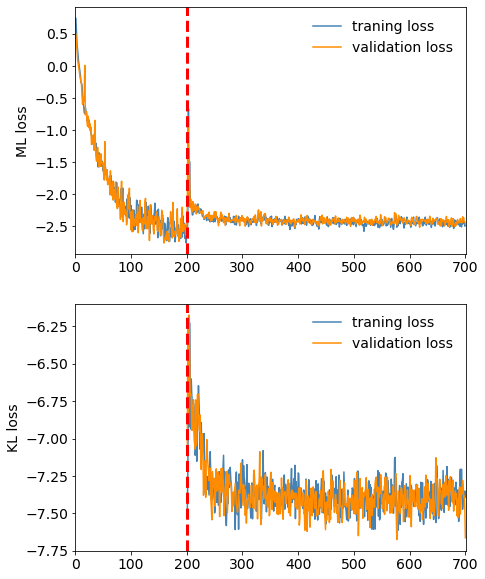

In [77]:
plot_KLML(hist1, hist2, 0,2)

### 4. Testing using trained generator

In [78]:
_, sample_x1, _, sample_e1, sample_logw1 = network1.sample(temperature=1.0, nsample=100000)
_, sample_x2, _, sample_e2, sample_logw2 = network2.sample(temperature=1.0, nsample=100000)
_, sample_x3, _, sample_e3, sample_logw3 = network3.sample(temperature=1.0, nsample=100000)

In [79]:
# Generate simulation as reference 
sampler.reset(x0_left)
sampler.run(100000)
traj_left_ref = sampler.traj.copy()
sampler.reset(x0_right)
sampler.run(100000)
traj_right_ref = sampler.traj.copy()
x_ref=np.vstack([traj_left_ref, traj_right_ref])

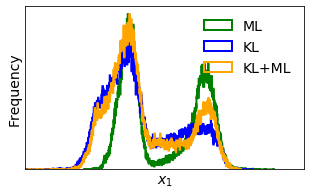

In [80]:
# position visualization
plt.figure(figsize=(5,3))
nsample = 100000
plt.hist(sample_x1[:, 0], 1000, histtype='step', color='green', linewidth=2, label='ML');
plt.hist(sample_x2[:, 0], 1000, histtype='step', color='blue', linewidth=2, label='KL');
plt.hist(sample_x3[:, 0], 1000, histtype='step', color='orange', linewidth=2, label='KL+ML');
plt.xlim(-2, 2)
plt.yticks([]);
plt.xlabel('$x_1$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc='upper right', frameon=False)

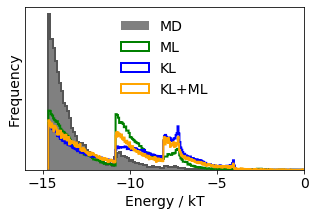

In [83]:
plt.figure(figsize=(5,3))
nsample = 100000
energy_md = mueller.energy(x_ref)
plt.hist(energy_md, 100, density=True, color='grey', linewidth=1, label='MD');
plt.hist(energy_md, 100, density=True, histtype='step', color='#555555', linewidth=2);
plt.hist(sample_e1, 1000, density=True, histtype='step', color='green', linewidth=2, label='ML');
plt.hist(sample_e2, 1000, density=True, histtype='step', color='blue', linewidth=2, label='KL');
plt.hist(sample_e3, 1000, density=True, histtype='step', color='orange', linewidth=2, label='KL+ML');
plt.xlim(-16, 0)
plt.yticks([]);
plt.xlabel('Energy / kT')
plt.ylabel('Frequency')
plt.legend(ncol=1, loc=9, fontsize=14, frameon=False)

### X_proj

In [85]:
# Free energy:
proj_dir = np.array([[0.7],[-0.7]])
proj1 = sample_x1.dot(proj_dir)
proj2 = sample_x2.dot(proj_dir)
proj3 = sample_x3.dot(proj_dir)

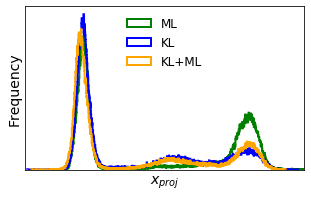

In [86]:
plt.figure(figsize=(5,3))
nsample = 100000
plt.hist(proj1[:, 0], 1000, histtype='step', color='green', linewidth=2, label='ML');
plt.hist(proj2[:, 0], 1000, histtype='step', color='blue', linewidth=2, label='KL');
plt.hist(proj3[:, 0], 1000, histtype='step', color='orange', linewidth=2, label='KL+ML');
plt.xlim(-2, 1)
plt.yticks([]);
plt.xlabel('$x_{proj}$')
plt.ylabel('Frequency')
plt.xticks([]);
plt.legend(ncol=1, loc=9, fontsize=12, frameon=False)

### Free energy plot

In [87]:
# Reference calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
xwild_proj = xwild.dot(proj_dir)

/home/fanglin/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/fanglin/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/fanglin/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


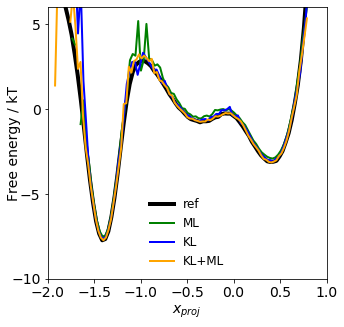

In [98]:
plt.figure(figsize=(5, 5))
hist1, bin_edges1 = np.histogram(proj1[:, 0], bins=100, weights=np.exp(sample_logw1-sample_logw1.max()))
bin_values1 = 0.5*(bin_edges1[:-1] + bin_edges1[1:])
hist2, bin_edges2 = np.histogram(proj2[:, 0], bins=100, weights=np.exp(sample_logw2-sample_logw2.max()))
bin_values2 = 0.5*(bin_edges2[:-1] + bin_edges2[1:])
hist3, bin_edges3 = np.histogram(proj3[:, 0], bins=100, weights=np.exp(sample_logw3-sample_logw3.max()))
bin_values3 = 0.5*(bin_edges3[:-1] + bin_edges3[1:])
hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_values_ref, -np.log(hist_ref), color='black', linewidth=4,label='ref')
plt.plot(bin_values1, -np.log(hist1)-1.5, color='green', linewidth=2,label='ML')
plt.plot(bin_values2, -np.log(hist2)-1.2, color='blue', linewidth=2,label='KL')
plt.plot(bin_values3, -np.log(hist3)-1.2, color='orange', linewidth=2,label='KL+ML')
plt.xlim(-2, 1)
plt.ylim(-10, 6)
plt.yticks([-10, -5, 0, 5])
plt.xlabel('$x_{proj}$')
plt.ylabel('Free energy / kT', labelpad=-10)
plt.legend(ncol=1, loc=8, fontsize=12, frameon=False)

### Paths

In [99]:
xpaths = []
for i in range(10):
    x1 = traj_left[np.random.randint(100)] 
    x2 = traj_right[np.random.randint(100)]
    xpaths.append(latent_interpolation(network3, x1, x2, nstep=1000))

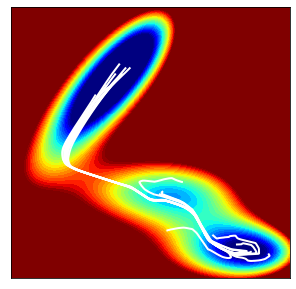

In [100]:
plot_potential(cbar=False, figsize=(5, 5))
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')
for xpath in xpaths:
    plt.plot(xpath[:, 0], xpath[:, 1], linewidth=2, color='white')